<a href="https://colab.research.google.com/github/jvuyvico/Autocolorization-Encoder/blob/main/2015_04617_Uyvico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
EPOCH: 499 --> Train_loss: 0.42533573508262634 , Test_loss: 0.5709183635190129
Done Training


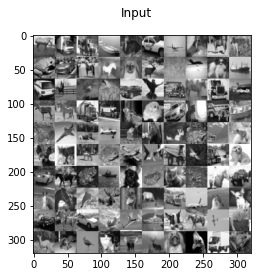

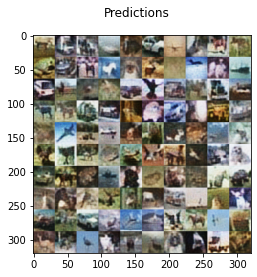

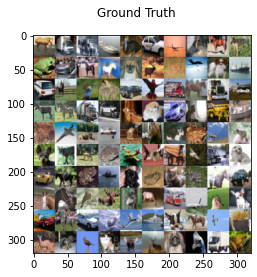

In [ ]:
import torch
import torchvision
import torchsummary

import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision import models
from torchsummary import summary
import cv2
import numpy as np 

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

cifar_dataset = cifar_dataset.data

batch_size = 100
output_data = np.array([cifar_dataset[_ix:_ix+batch_size] for _ix in range(0, cifar_dataset.shape[0], batch_size)])
input_data = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in cifar_dataset])
input_data = np.array([input_data[_ix:_ix+batch_size] for _ix in range(0, input_data.shape[0], batch_size)])

train_ratio, test_ratio = 0.8, 0.2
rand_ix = input_data.shape[0]
rand_ix = np.arange(100)
train_ix, test_ix = rand_ix[:int(train_ratio*rand_ix.shape[0])], rand_ix[int(test_ratio*rand_ix.shape[0]):]
x_train, y_train, x_test, y_test = input_data[train_ix,:,:], output_data[train_ix,:,:], input_data[test_ix,:,:], output_data[test_ix,:,:]

def transform_and_create_torch_tensors(data):
    data = torch.from_numpy(data).float().to(device)
    return data.contiguous().view(data.size(0),batch_size,-1,32,32)

x_train, y_train, x_test, y_test = map(transform_and_create_torch_tensors, [x_train, y_train, x_test, y_test])

mean = torch.mean(x_train[:,:,0,:,:])
std = torch.std(x_train[:,:,0,:,:])
x_train[:,:,0,:,:] = (x_train[:,:,0,:,:]-mean)/std
x_test[:,:,0,:,:] = (x_test[:,:,0,:,:]-mean)/std
y_train = y_train/255
y_test = y_test/255

class ConvNet(nn.Module):

    def __init__(self, batch_size):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.linear1 = nn.Linear(32*7*7, 512)
        self.linear2 = nn.Linear(512, 3072)

    def forward(self, x):
        # Encoder Phase
        p1 = F.max_pool2d(self.conv1(x), (2,2))
        p2 = F.max_pool2d(self.conv2(p1), (2,2))
        # Decoder Phase
        f1 = F.relu(self.linear1(p2.view(batch_size,-1)))
        f2 = torch.sigmoid(self.linear2(f1)).view(-1, 3, 32, 32)
        return f2

learning_rate = 0.0001
epochs = 500
criterion = torch.nn.MSELoss()

net = ConvNet(batch_size)
net.to(device)

'''
display model summary:

vgg = models.vgg16()
summary(vgg.cuda(), (3, 224, 224))
'''

optimizer = optim.Adam(net.parameters(), lr=learning_rate)

train_loss_container, test_loss_container = [], []

for e in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    
    for batch, train_data in enumerate(x_train):
        ip, op = train_data, y_train[batch]
        optimizer.zero_grad()
        model_op = net(ip)
        loss = criterion(model_op, op)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for batch_test, test_data in enumerate(x_test, 0):
            ip_test, op_test = test_data, y_test[batch_test]
            model_op = net(ip_test)
            loss_test = criterion(model_op, op_test)
            test_loss += loss_test.item()
    
    train_loss_container.append(train_loss)
    test_loss_container.append(test_loss)
    print('\rEPOCH: {} --> Train_loss: {} , Test_loss: {}'.format(e, train_loss, test_loss), end='')
print('\nDone Training')

dump1 = np.zeros((32,32))
dump2 = np.zeros((32,320))
for i in range(10):
    for j in range(10):

        tmp = mean.item()+x_test[i][j].detach().cpu().squeeze().numpy()*std.item()
        
        dump1 = np.concatenate((dump1,tmp), axis=1)
    dump2 = np.concatenate((dump2, dump1[:,32:352]), axis=0)
    dump1 = np.zeros((32,32))
fig1, ax1 = plt.subplots()
fig1.suptitle('Input')
ax1.imshow(dump2[32:352, :].astype(np.uint8), cmap='gray')

dump1 = np.zeros((32,32,3))
dump2 = np.zeros((32,320,3))
for i in range(10):
    for j in range(10):
        
        tmp = net(x_test[i])[j].detach().cpu().numpy().reshape(32,32,3)*255
        
        dump1 = np.concatenate((dump1,tmp), axis=1)
    dump2 = np.concatenate((dump2, dump1[:,32:352,:]), axis=0)
    dump1 = np.zeros((32,32,3))
fig2, ax2 = plt.subplots()
fig2.suptitle('Predictions')
ax2.imshow(dump2[32:352, :].astype(np.uint8))

dump1 = np.zeros((32,32,3))
dump2 = np.zeros((32,320,3))
for i in range(10):
    for j in range(10):
       
        tmp = y_test[i][j].detach().cpu().numpy()*255
        
        tmp = tmp.reshape(32,32,3)
        dump1 = np.concatenate((dump1,tmp), axis=1)
    dump2 = np.concatenate((dump2, dump1[:,32:352,:]), axis=0)
    dump1 = np.zeros((32,32,3))
fig3, ax3 = plt.subplots()
fig3.suptitle('Ground Truth')
ax3.imshow(dump2[32:352,:].astype(np.uint8))